### Генерация признаков и классификация только на вейвлет преобразовании

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_selection import f_classif
%matplotlib inline

In [2]:
filename = 'DATA/EEG_MentalInfo.pickle'
with open(filename, 'rb') as f:
    EEG_info = pickle.load(f)
EEG_info.keys()    

dict_keys(['list_EmptySl', 'Table', 'chanNames', 'list_Mem', 'list_Sl', 'list_Empty', 'list_Im'])

In [3]:
Im_names = EEG_info['list_Im']
Mem_names = EEG_info['list_Mem']
Sl_names = EEG_info['list_Sl']
Empty_names = EEG_info['list_Empty'] 
EmptySl_names = EEG_info['list_EmptySl']
chan_names = EEG_info['chanNames']

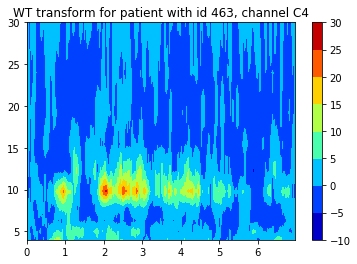

In [4]:
name = Im_names[6]
resname = 'ResultsData/'+ 'ResultD000'+str(name)+'.pickle'
with open(resname, 'rb') as f:
    res = pickle.load(f)
wt = res['normWT']
ch_id = 10
plt.contourf(res['timeExp(s)'], res['freq'], wt[:,:,ch_id], cmap= plt.cm.jet ); plt.colorbar()
plt.title('WT transform for patient with id {}, channel {}'.format(name, chan_names[ch_id]));

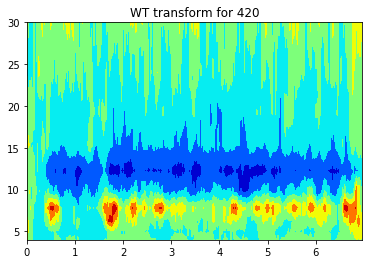

In [5]:
name = Sl_names[0]
resname = 'ResultsData/'+ 'ResultD000'+str(name)+'.pickle'
with open(resname, 'rb') as f:
    res = pickle.load(f)
plt.contourf(res['timeExp(s)'], res['freq'], res['normWT'][:,:,18], cmap=plt.cm.jet ); plt.title('WT transform for {}'.format(name));

In [6]:
def wav_feature_generator(name, start = 800, end = 3000, loadData = True):
    """
    function for generation features from wt images
    take name of fail with results
    start and time for averaging
    return feature vector
    """
    
    if loadData:
        resname = 'ResultsData/'+ 'ResultD000'+str(name)+'.pickle'
        with open(resname, 'rb') as f:
            res = pickle.load(f)
        wt = res['normWT'] 
    else:
        wt = name  
      
    mean_theta = np.mean(np.mean(wt[0:3,start:end,:], axis = 1), axis = 0).reshape(1,-1)
    mean_alpha1 = np.mean(np.mean(wt[3:5,start:end,:], axis = 1), axis = 0).reshape(1,-1)
    mean_alpha2 = np.mean(np.mean(wt[5:7,start:end,:], axis = 1), axis = 0).reshape(1,-1)
    mean_beta1 = np.mean(wt[7,start:end,:], axis = 0).reshape(1,-1)
    mean_beta2 = np.mean(np.mean(wt[8:,start:end,:], axis = 1), axis = 0).reshape(1,-1)

    wav_features = np.concatenate([mean_theta, mean_alpha1,mean_alpha2, mean_beta1, mean_beta2], axis = 1)     
    return np.squeeze(wav_features)    

In [7]:
def findIdxFromTime(times, time = [1.5,2.5]):
    """
    take time in second and return series index
    """
    idx  = [np.argmin(np.abs(times *0.002 - t)) for t in time]
    return idx

In [8]:
times = np.arange(3480)
findIdxFromTime(times, time = [1.5,2.5])

[750, 1250]

In [9]:
def process_group_wt(group, times, time = [1,2]):
    
    start, end = findIdxFromTime(times, time)
    Features = []
    
    for name in group:
        features  = wav_feature_generator(name, start, end)
        Features.append(features)
    return np.array(Features)       

In [12]:
#посмотрим на какой-нибудь группе
time_interval = [1,2]
testWT = process_group_wt(Mem_names, times, time = time_interval)
testWT.shape

(28, 95)

In [10]:
rithms = ['theta','alpha1','alpha2', 'beta1', 'beta2']
iterables = [rithms, chan_names]
indexCol = pd.MultiIndex.from_product(iterables, names=['rhitms', 'channels'])

In [14]:
#Посмотрим как выглядят признаки, выберем несколько случайно
numF = 10
bestF = np.random.randint(0, 94,numF)
time_interval = [1,2]
ListNames = [Im_names,Mem_names, Sl_names, Empty_names, EmptySl_names]
wtFeaturesList = [process_group_wt(names, times, time = time_interval) for names in ListNames]
wtMeans = [np.mean(wtFeatures[:,bestF], axis = 0) for wtFeatures in wtFeaturesList]
colnames = [indexCol[i] for i in bestF]
df = pd.DataFrame(wtMeans, index=['Im','Mem','Sl','Empty', 'EmptySl'], columns=colnames)
df

,"(alpha2, T5)","(theta, O2)","(beta1, F4)","(alpha1, P3)","(alpha2, Pz)","(beta1, F4)","(alpha2, Cz)","(alpha1, F8)","(theta, F7)","(beta2, P3)"
Im,-0.457407,0.700304,-0.049806,-0.418981,-0.071419,-0.049806,-0.127297,0.854622,1.712086,0.070077
Mem,0.699702,0.389982,-0.793801,-0.415462,0.146113,-0.793801,-0.430129,0.365220,0.553651,0.143967
Sl,-1.671664,0.823913,-1.386238,-0.135942,-2.174468,-1.386238,-1.944984,-0.752085,-0.015659,-0.998204
Empty,0.455725,-0.207037,-0.644998,-0.222841,0.270325,-0.644998,-0.508785,0.130343,0.501756,-0.138916
EmptySl,-0.470959,3.017728,-0.892666,1.771796,-0.227796,-0.892666,-0.891369,-0.602992,0.272708,-0.664941


### Выделение значимых различий между двумя группами
Сделаем тест на разницу между средними и найдем те признаки, в которых она проявляется. В качестве теста возьмем F-тест.


In [15]:
from sklearn.feature_selection import f_classif

Time interval: [2, 3] Max score: 58.084302167110174 signif number 71


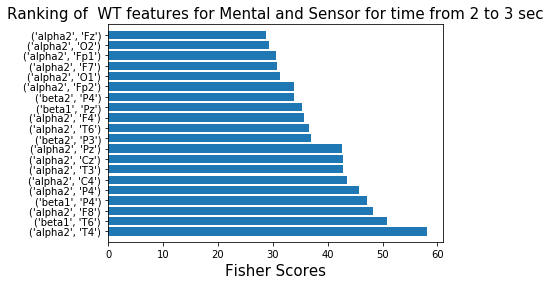

In [31]:
#для разницы в сенсорном и ментальном внимании 
time_interval = [2,3]
ListNames = [Im_names,Mem_names, Sl_names, Empty_names, EmptySl_names]
wtFeaturesList = [process_group_wt(names, times, time = time_interval) for names in ListNames]
wtImMem = np.concatenate(wtFeaturesList[:3])
#y2 = np.concatenate([np.zeros(len(Im_names)), np.ones(len(Mem_names))])
y2 = np.concatenate([np.zeros(len(Im_names)+len(Mem_names)), np.ones(len(Sl_names))])

scoresF = f_classif(wtImMem, y2)
numF = sum(scoresF[1]<0.05)
print('Time interval:',time_interval,'Max score:', np.max(scoresF[0]),'signif number', numF)

#plot graph
if numF>20 : numF=20 
bestF = np.argsort(scoresF[0])[::-1][:numF]
ordCols = [indexCol[i] for i in bestF]

y_pos2 = np.arange(numF)
plt.barh(y_pos2, scoresF[0][bestF], align='center')
plt.ylim((-1, numF))
plt.yticks(y_pos2, ordCols)
plt.xlabel('Fisher Scores', fontsize=15)
plt.title('Ranking of  WT features for Mental and Sensor for time from {} to {} sec'.format(time_interval[0],time_interval[1]), fontsize=15);

In [28]:
#сделайте то же самое для воображения и воспоминания

In [32]:
#Посчитаем для всех временных интервалов и запишем данные в табличку
writer = pd.ExcelWriter('ExcelReports/SensorVsMentalWT.xlsx')
time_intervals = [[1,2],[2,3],[3,4],[5,6],[5.5,6.5]]
for time_interval in time_intervals:
    ListNames = [Im_names,Mem_names, Sl_names, Empty_names, EmptySl_names]
    wtFeaturesList = [process_group_wt(names, times, time = time_interval) for names in ListNames]
    wtComp = np.concatenate(wtFeaturesList[:3])

    y2 = np.concatenate([np.zeros(len(Im_names)+len(Mem_names)), np.ones(len(Sl_names))])
    scoresF = f_classif(wtComp, y2)
    numF = sum(scoresF[1]<0.05)
    print('Time interval:',time_interval,'Max score:', np.max(scoresF[0]),'signif number', numF)

    bestF = np.argsort(scoresF[0])[::-1][:numF]
    wtMeans = [np.mean(wtFeatures[:,bestF], axis = 0) for wtFeatures in wtFeaturesList]
    colnames = [indexCol[i] for i in bestF]

   
    data = np.vstack([wtMeans, scoresF[0][bestF]])
    df = pd.DataFrame(data, index=['Im','Mem','Sl','Empty', 'EmptySl','F_score'], columns=colnames)
    df.to_excel(writer,'Time({}-{})s'.format(time_interval[0],time_interval[1]),float_format = '%.2f')
writer.save()   

Time interval: [1, 2] Max score: 42.08275199672976 signif number 57
Time interval: [2, 3] Max score: 58.084302167110174 signif number 71
Time interval: [3, 4] Max score: 49.67583424864806 signif number 75
Time interval: [5, 6] Max score: 42.38837081828891 signif number 71
Time interval: [5.5, 6.5] Max score: 42.56705501909504 signif number 69


In [33]:
df.head()

,"(beta1, T6)","(alpha2, T4)","(alpha2, T6)","(alpha2, C4)","(beta1, P4)","(alpha2, Fp2)","(alpha2, T3)","(alpha2, T5)","(alpha2, Pz)","(beta2, P3)",...,"(beta2, T3)","(alpha1, F8)","(beta2, Cz)","(beta2, F7)","(alpha1, C4)","(beta2, F4)","(beta2, Fp2)","(alpha1, Pz)","(beta2, C3)","(alpha1, O2)"
Im,-0.216889,0.308794,-0.234722,0.067900,-0.437859,-0.579578,-0.399640,-0.868180,0.196121,-0.384780,...,-0.086913,1.003521,-0.659364,-0.295745,0.817105,-0.502984,-0.386514,2.602600,-0.560165,5.390284
Mem,-0.092854,0.438611,0.960703,0.424066,0.046368,-0.176577,-0.485614,0.709017,1.263619,-0.469286,...,0.014217,1.589176,-0.910467,-0.355198,1.765154,-0.548213,-0.144132,3.035300,-0.819860,4.996861
Sl,-3.031139,-1.688180,-3.854093,-2.597837,-2.974110,-2.733819,-1.852663,-3.144554,-3.089729,-1.595875,...,-0.555310,-1.131152,-1.405850,-0.773814,-0.943096,-1.016929,-0.713967,-1.112529,-1.153985,-1.004899
Empty,-0.632753,-0.355260,-0.251564,-0.415642,-0.556649,-0.714685,-0.455274,-0.018709,0.092942,-0.863712,...,-0.342149,1.170182,-1.036957,-0.130601,0.799818,-0.601763,-0.451640,1.163915,-1.129080,1.149764
EmptySl,-1.580258,-1.608761,-2.786218,-1.981914,-1.808417,-2.512040,-0.844224,-2.367030,-1.657956,-1.350291,...,-0.133656,-0.525179,-0.877931,-0.447827,0.171332,-0.367728,-0.297601,1.401822,-1.009093,-0.933489


In [35]:
#То же самое для разницы внутри воображения и воспоминания, поставим уровень пониже
writer = pd.ExcelWriter('ExcelReports/MentalVsSensorWT.xlsx')
time_intervals = [[1,1.5],[1.5,2],[2,2.5],[2.5,3],[3,3.5],[3.5,4],[4.5,5],[5,6],[5.5,6.5]]
for time_interval in time_intervals:
    ListNames = [Im_names,Mem_names, Sl_names, Empty_names, EmptySl_names]
    wtFeaturesList = [process_group_wt(names, times, time = time_interval) for names in ListNames]
    wtComp = np.concatenate(wtFeaturesList[:2])

    y2 = np.concatenate([np.zeros(len(Im_names)), np.ones(len(Mem_names))])
    scoresF = f_classif(wtComp, y2)
    numF = sum(scoresF[1]<0.1)
    print('Time interval:',time_interval,'Max score:', np.max(scoresF[0]),'signif number', numF)

    bestF = np.argsort(scoresF[0])[::-1][:numF]
    wtMeans = [np.mean(wtFeatures[:,bestF], axis = 0) for wtFeatures in wtFeaturesList]
    colnames = [indexCol[i] for i in bestF]

   
    data = np.vstack([wtMeans, scoresF[0][bestF]])
    df = pd.DataFrame(data, index=['Im','Mem','Sl','Empty', 'EmptySl','F_score'], columns=colnames)
    df.to_excel(writer,'Time({}-{})s'.format(time_interval[0],time_interval[1]),float_format = '%.2f')
writer.save()    

Time interval: [1, 1.5] Max score: 8.021464468763668 signif number 18
Time interval: [1.5, 2] Max score: 5.480406205265914 signif number 8
Time interval: [2, 2.5] Max score: 9.429755623815302 signif number 6
Time interval: [2.5, 3] Max score: 6.168748547195344 signif number 1
Time interval: [3, 3.5] Max score: 3.4742570011563463 signif number 1
Time interval: [3.5, 4] Max score: 3.8012562033717354 signif number 2
Time interval: [4.5, 5] Max score: 4.667178533255041 signif number 5
Time interval: [5, 6] Max score: 4.8847184585494485 signif number 8
Time interval: [5.5, 6.5] Max score: 5.228558325474202 signif number 6


In [36]:
df

,"(alpha2, T5)","(theta, T5)","(theta, T6)","(theta, Pz)","(theta, P4)","(theta, P3)"
Im,-0.868180,-1.169956,-1.280141,-0.937954,-0.962734,-0.717815
Mem,0.709017,-0.126245,-0.460844,-0.131386,-0.283560,0.057721
Sl,-3.144554,-1.085369,-1.132764,-0.296013,-0.584588,-0.263588
Empty,-0.018709,-0.952991,-1.045433,-0.678034,-0.864216,-0.785441
EmptySl,-2.367030,-1.206464,-1.078911,-0.541694,-0.731671,-0.722628
F_score,5.228558,4.487065,4.225703,4.097899,3.422457,3.392800
